In [1]:
import time
import sys

import numpy as np
import scipy as sp
import pandas as pd

from scipy.stats import poisson
from scipy.stats import zipf

import matplotlib as mp
import matplotlib.pyplot as plt

In [2]:
# Package for sampling from ESC models
from escsamp import *
# Package for computing Bell polynomials
from bell import *

# escsamp and bell make use of functions in logfac.py
# for computing logarithms of binomial coefficients
# and logarithms of factorials.

## ESC-NB

Generate from the ESC-NB model and plot the resulting cluster size distribution against that predicted by our theoretical results.

In [3]:
# Set parameters of the model: 500 observations; set the p and r parameters of the negative binomial.
# Code should run in reasonable time on a laptop or desktop for values of nn up to 5K-10K, depending on memory.
(nn,pp,rr) = (500,0.5,2.0)

NMC=200 # Number of MC replicates of the timing experiment.

In [4]:
# Below is demo code for setting up an ESCsampler object for the Negative Binomial.
# To set that up, we need to set up a function that takes in a single non-negative integer argument
# and returns (log of) mu_k, where mu is the vector of cluster size probabilities.

# First, we set up that function.

# Compute logarithm of the binomial coefficient n choose k.
def logbinom( n, k ):
    if n<0:
        return (-1)**k * logbinom( n+k-1, k)
    if k<0:
        return -np.inf # n choose k is 0 when k < 0.
    else:
        return spsp.loggamma( n+1 ) - spsp.loggamma(k+1) - spsp.loggamma(n-k+1)
logbinom = np.vectorize( logbinom )

# Compute logarithm of mu_k under the Negative Binomial
def logmu_nb_fn(k, p=0.5, r=1):
    if k==0:
        return -np.inf
    else:
        return r*np.log(1-p) + (k-1)*np.log(p) + logbinom( k+r-2, k-1 )

# Our ESCsampler object expects a function that takes a single non-negative integer argument
# and returns mu_k, so we create said function by fixing the p and r arguments to be our parameters above
logmu_nb = lambda k : logmu_nb_fn(k, p=pp, r=rr )

def loguseq_nb_fn(n,p=0.5,r=1):
    n = int(n)
    if n < 0:
        raise ValueError('Index must be non-negative.')
    if n==0:
        return 0.0 # = log 1; There is always a renewal at time t=0.
    kseq = np.arange(1,n+1)
    # We need to take a summation, but we get an overflow if we do.
    # So take logs, then use logaddexp.
    #logp = np.log(p)
    #logpfrac = r*np.log(1-p) - (n-k)*logp
    logbins = logbinom( n + (r-1)*kseq-1, n-kseq )
    summands = kseq*r*np.log(1-p) + logbins + (n-kseq)*np.log(p)
    return np.logaddexp.reduce( summands )

# Pr[E_n] computed for NB in the manuscript.
logu_nb = lambda k : loguseq_nb_fn( k, p=pp, r=rr )

esc_nb_useq = ESCsampler( nn, logmu_nb, logu_nb )

In [5]:
# To generate samples from the "naive" sampler, the ESCsampler object requires access
# to a function that takes no arguments and returns a single draw from the cluster size distribution.
# We set the success probability p to be 1-pp because the parameterization of
# scipy's negative binomial is opposite to our notation.
def gen_nb():
    return np.random.negative_binomial( n=rr, p=1-pp, size=1 ) + 1 # Add one to shift the distribution.

# Track the runtimes and the number of clusters over our NMC replicates.
naive_times = np.zeros(NMC)
naive_K = np.zeros(NMC)
for i in range(NMC):
    t1 = time.time()
    clusts = esc_nb_useq.generate_naive_exact( gen_nb )
    t = time.time() - t1
    naive_times[i] = t
    naive_K[i] = len(clusts)
np.mean(naive_times)

0.045287643671035764

In [6]:
# Time the precomputation effort required by the Bell-based sampler.
t1=time.time()
esc_nb_useq.precompute()
t = time.time() - t1
bell_sunktime = t

print('precomp finished in %f seconds.' % t)

# Track the runtimes and the number of clusters over our replicates.
bell_times = np.zeros(NMC)
bell_K = np.zeros(NMC)
for i in range(NMC):
    t1 = time.time()
    clusts = esc_nb_useq.generate()
    t = time.time() - t1
    bell_times[i] = t
    bell_K[i] = len(clusts)

# Compute the (mean) amortized runtime. This is the mean runtime
# plus the time required by precomputation, averaged over the NMC samples.
np.mean(bell_times) + bell_sunktime/NMC

Precomputing logmuseq...
Precomputing loguseq...
Precomputing Xprob...
Finished with precomputing.
precomp finished in 0.880942 seconds.


0.012525191307067871

In [7]:
# Compute range of K values (i.e., number of clusters)
# for the sake of plotting.
Kmax = max( [np.max( naive_K ), np.max( bell_K )] )
Kmin = min( [np.min( naive_K ), np.min( bell_K )] )
kseq = np.arange(int(Kmin),int(Kmax)+1)

In [8]:
# Function for computing the distribution of the number of clusters K.
# Based on Theorem 3 in the manuscript.
def nb_kprob( k, n, p=0.5, r=1.0 ):
    # For stability, compute in log space, and THEN exponentiate.
    logdenom = loguseq_nb_fn(n,p=p,r=r)
    lognumer = (n-k)*np.log(p) + r*k*np.log(1-p)
    logbin = logbinom( n+k*(r-1)-1, n-k )
    return np.exp( lognumer + logbin - logdenom )

pred_density = nb_kprob( kseq, nn, pp, rr )

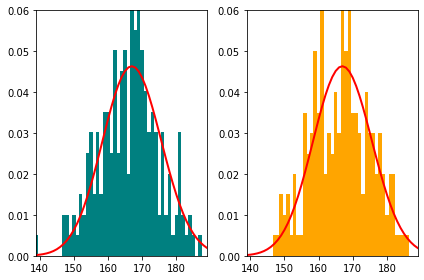

In [9]:
# Plot the resulting histograms, overlaid with the theoretical distribution of K.
(Kmin,Kmax) = (int(Kmin), int(Kmax))
x=np.arange(Kmin,Kmax+1)
plt.subplot(121)
(naive_density, naive_bins, _) =  plt.hist( naive_K, color='teal', density=True, bins=x-0.5)
plt.plot(x, pred_density[x-Kmin], color='red', linewidth=2)
plt.ylim(0,0.06)
plt.xlim(int(Kmin),int(Kmax))
plt.subplot(122)
(bell_density, bell_bins, _) = plt.hist(bell_K, color='orange', density=True, bins=x-0.5)
plt.plot(x, pred_density[x-Kmin], color='red', linewidth=2)
plt.ylim(0,0.06)
plt.xlim(int(Kmin),int(Kmax))

plt.tight_layout()

In [10]:
# Create a data frame and...
nbdf = pd.DataFrame( {'K':kseq[:-1], 'Naive':naive_density, 'Bell':bell_density, 'Predicted':pred_density[:-1] } )
nbdf

,K,Naive,Bell,Predicted
0,139,0.005025,0.000,0.000187
1,140,0.000000,0.000,0.000277
2,141,0.000000,0.000,0.000406
3,142,0.000000,0.000,0.000585
4,143,0.000000,0.000,0.000831
5,144,0.000000,0.000,0.001162
6,145,0.000000,0.000,0.001601
7,146,0.000000,0.000,0.002172
8,147,0.010050,0.005,0.002902
9,148,0.010050,0.005,0.003822


In [11]:
# ...save it to a CSV
nbdf.to_csv('nb_hist.csv', index=False)

## Zipf

Generate from the ESC-Zipf model and plot the resulting cluster size distribution against that predicted by our theoretical results.

For more on the Zipf distribution, see https://en.wikipedia.org/wiki/Zipf%27s_law

In [12]:
(n,ALPHA) = (500,1.05) # Number of observations n and the ALPHA parameter controlling the Zipf distribution.
if ALPHA <= 1.0:
    raise ValueError('alpha parameter must be > 1 for Zipf to be well-defined.')
NMC=200

mu_zipf = lambda k : zipf.pmf(k, ALPHA) # Computes the cluster size distribution, mu_k
# Normalizing constant and its logarithm.
zetaalpha = spsp.zeta( ALPHA )
logZA = np.log( zetaalpha )

'''Naive x_zipf computation causes over/underflows when k is big.
    x_zipf = lambda k : k! mu_k
    log of this is logfac(k) + log mu_zipf(k)
    So we'll compute everything in log-space.
'''

# Similar to our NB example above, we need a function for computing logarithms of
# this probability distribution.
def logmu_zipf_full( k, a ):
    if k==0: # mu_0 = 0 definitionally.
        return -np.inf
    else:
        return -ALPHA*np.log(k) -logZA
logmu_zipf = lambda k : logmu_zipf_full( k, ALPHA )

esc_zipf = ESCsampler( n, logmu_zipf )

In [13]:
# Function for generating a single draw from the Zipf distribution
# required by our naive procedure.
def gen_zipf():
    return np.random.zipf( a=ALPHA, size=1 )

# Track the runtimes and the number of clusters over our NMC replicates.
naive_times = np.zeros(NMC)
naive_K = np.zeros(NMC)
for i in range(NMC):
    t1 = time.time()
    clusts = esc_zipf.generate_naive_exact( gen_zipf )
    t = time.time() - t1
    naive_times[i] = t
    naive_K[i] = len(clusts)

np.mean(naive_times)

0.18730228900909424

In [14]:
# Time the precomputation effort required by the Bell polynomial-based method
t1=time.time()
esc_zipf.precompute()
t = time.time() - t1
bell_sunktime = t

print('Precomputation finished in %f seconds.' % t)

bell_times = np.zeros(NMC)
bell_K = np.zeros(NMC)
for i in range(NMC):
    t1 = time.time()
    clusts = esc_zipf.generate()
    t = time.time() - t1
    bell_times[i] = t
    bell_K[i] = len(clusts)
    
# Compute the amortized mean runtime.
np.mean(bell_times) + bell_sunktime/NMC

Precomputing logmuseq...
Precomputing loguseq...
Precomputing Xprob...
Finished with precomputing.
Precomputation finished in 3.579104 seconds.


0.018003857135772704

In [15]:
# The ESCsampler object also has a method for computing Pr[ K_n = k ]
# for k=1,2,...,n
# using the Bell polynomial identities referenced in Section 2.4
# Retrieve those values so that we can plot them below.
zipf_k = esc_zipf.Kprob()

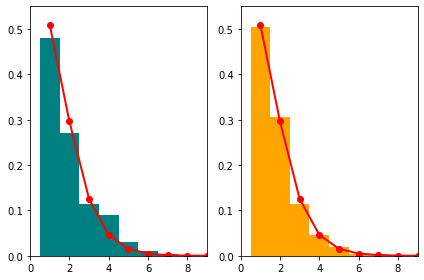

In [16]:
x=np.arange(1,10)
plt.subplot(121)
(naive_density, naive_bins, patches) =  plt.hist( naive_K, color='teal', density=True, bins=x-0.5)
plt.plot(x, zipf_k[x], color='red', linewidth=2, marker='o')
plt.ylim(0,0.55)
plt.xlim(0,9)
plt.subplot(122)
(bell_density, bell_bins, patches) = plt.hist(bell_K, color='orange', density=True, bins=x-0.5)
plt.plot(x, zipf_k[x], color='red', linewidth=2, marker='o')
plt.ylim(0,0.55)
plt.xlim(0,9)

plt.tight_layout()

In [17]:
# Vector of K-values to pass into a dataframe along with the densities
kseq = range(1,len(naive_density)+1)
# Vector of predicted densities to pass into a dataframe.
pred_density = np.array([ zipf_k[ int(k) ] for k in kseq ] )
# Create a data frame and...
zipfdf = pd.DataFrame( {'K':kseq, 'Naive':naive_density, 'Bell':bell_density, 'Predicted':pred_density } )
zipfdf

,K,Naive,Bell,Predicted
0,1,0.480,0.505,0.509427
1,2,0.270,0.305,0.296356
2,3,0.115,0.115,0.125620
3,4,0.090,0.045,0.046123
4,5,0.030,0.020,0.015509
5,6,0.010,0.005,0.004899
6,7,0.005,0.005,0.001475
7,8,0.000,0.000,0.000427


In [18]:
# ...save it to a CSV
zipfdf.to_csv('zipf_hist.csv', index=False)